In [109]:
#useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.optimization.applications.ising import max_cut,tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely

#setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
#set qiskit_aqua_logging(logging.DEBUG) #choose INFO, DEBUG to see the log

In [110]:
#Generating a graph of 3 nodes
n=4
num_qubits = n**2
ins = tsp.random_tsp(n)

In [111]:
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))

In [112]:
colors = {'r' for node in G.nodes()}
pos = {k: v for k, v in enumerate(ins.coord)}

distance
 [[ 0. 48. 50. 14.]
 [48.  0. 52. 49.]
 [50. 52.  0. 38.]
 [14. 49. 38.  0.]]


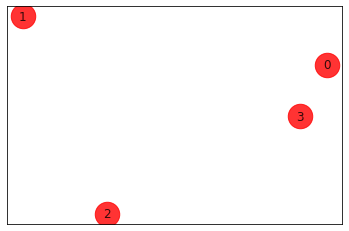

In [113]:
default_axes=plt.axes(frameon=True)
nx.draw_networkx(G,node_color=colors,node_size=600,alpha=.8,ax=default_axes,pos = pos)
print('distance\n',ins.w)

In [114]:
from itertools import permutations
#'''
def brute_force_tsp(w,N):
    a = list(permutations(range(1,N)))
    last_best_distance = 1e10
    for  i in a:
        distance = 0
        pre_j=0
        for j in i:
            distance=distance+w[j,pre_j]
            pre_j=j
        distance=distance+w[pre_j,0]
        order = (0,)+i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order='+str(order) + ' Distance = '+ str(distance))
    return last_best_distance, best_order
#'''

order=(0, 1, 2, 3) Distance = 152.0


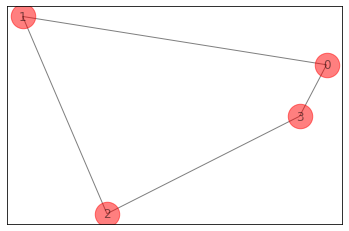

In [115]:
best_distance, best_order= brute_force_tsp(ins.w,ins.dim)
def draw_tsp_solution(G,order,colors,pos):
    G2=G.copy()
    n = len(order)
    for i in range(n):
        j=(i+1)%n
        G2.add_edge(order[i],order[j])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2,node_color=colors,node_size = 600,alpha=.5,ax=default_axes,pos=pos)
    
draw_tsp_solution(G,best_order,colors,pos)

In [116]:
qubitOp, offset = tsp.get_operator(ins)

In [117]:
#Create an instance of a model and variables
from docplex.mp.model import Model
from qiskit.optimization.applications.ising import docplex
mdl = Model(name = 'tsp')
x={(i,p):mdl.binary_var(name='x_{0}_{1}'.format(i,p)) for i in range(n) for p in range(n)}

In [118]:
#Object function
     
tsp_func = mdl.sum(ins.w[i,j]*x[(i,p)]*x[(j,(p+1)%n)] for i in range(n) for j in range(n) for p in range (n))
mdl.minimize(tsp_func)

In [119]:
# Constraints
for i in range(n):
   mdl.add_constraint(mdl.sum(x[(i,p)] for p in range(n))==1)
    
   
for p in range(n):
    mdl.add_constraint(mdl.sum(x[(i,p)] for i in range(n))==1)
    
for p in range(n):
    if x[(n-1,p)] is 1:
        yy = mdl.sum(x[(n-1,l)] for l in range(p+1,n))
        mdl.add_constraint(mdl.sum((1-yy))==0)
        
mdl.add_constraint(mdl.sum(x[(n-1,l)] for l in range(n-1,n)) == 1)
  
qubitOp_docplex, offset_docplex = docplex.get_operator(mdl)    

In [120]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp,k=1)
result = ee.run()

C:\Users\Wolfgang\Anaconda3\lib\site-packages\qiskit\aqua\algorithms\eigen_solvers\numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


energy: -1600350.0
tsp_objectives: 152.0
feasible True
solution: [2, 3, 0, 1]
solution_objective: 152.0


C:\Users\Wolfgang\Anaconda3\lib\site-packages\qiskit\aqua\algorithms\eigen_solvers\eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
C:\Users\Wolfgang\Anaconda3\lib\site-packages\qiskit\aqua\algorithms\eigen_solvers\eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
C:\Users\Wolfgang\Anaconda3\lib\site-packages\qiskit\aqua\algorithms\eigen_solvers\eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


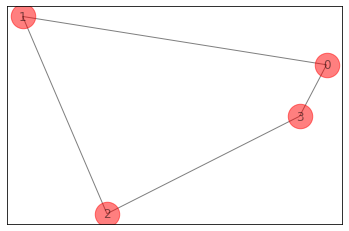

In [121]:
print('energy:',result['energy'])
print('tsp_objectives:',result['energy']+offset)
x= sample_most_likely(result['eigvecs'][0])
print('feasible',tsp.tsp_feasible(x))
z= tsp.get_tsp_solution(x)
print('solution:',z)
print('solution_objective:',tsp.tsp_value(z,ins.w))
draw_tsp_solution(G,z,colors,pos)